## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test
import friedman3Dataset
import network
import dataset
import sanityChecks
import performanceMetrics
import torch 
import numpy as np 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean 
import statsModel
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split

## Parameters
ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [23]:
#ABC Generator Parameters
abc_mean = 1
variance = 1

#Training parameters 
n_epochs = 1000

## Dataset

In [4]:
#Parameters 
n_features = 5
n_samples= 100
n_target = 1 

In [5]:
X, Y = friedman3Dataset.friedman3_data(n_samples)
# Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

        X1    X2    X3   X4     X5     X6    X7      X8   X9    X10   X11  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

      X12   X13     Y  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  


## Training Parameters 



In [24]:
batch_size = 32
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MSE Threshold and Mean Coeff Values 

Fetch coefficient values from stats model to be used in the ABC pre-generator 

Fetch MSE threshold for training the ABC-GAN 

The ABC-GAN will be trained until the threshold MSE is achieved or until it completes 5000 epochs 

The threshold mse is the mean mse of Catboost over 10 runs

In [ ]:
coeff , y_pred =statsModel.statsModel(X_train,Y_train,X_test,Y_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape)
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)

mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mae)

# ABC - GAN Model with skip connection

In [25]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))


In [ ]:
discLossA3,genLossA3 = ABC_train_test.training_GAN_skip_connection(disc3, gen3,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,abc_mean,variance,device)

sb.glue("ABC_GAN_3 Generator Loss",genLossA3)
sb.glue("ABC_GAN_3 Discriminator Loss",discLossA3)

In [ ]:
ABC_GAN3_metrics=ABC_train_test.test_generator(gen3,test_data,coeff,abc_mean,variance,device)

sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

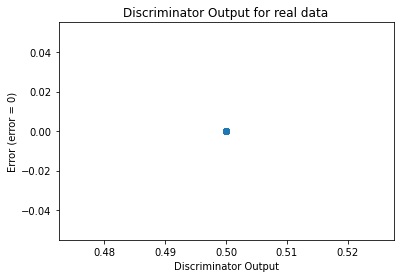

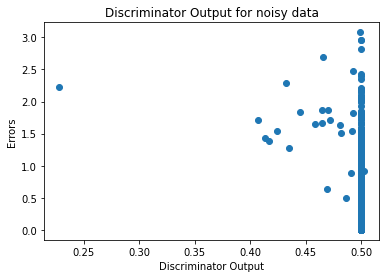

In [20]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [21]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0342]], requires_grad=True)


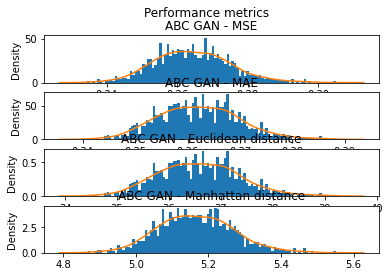

In [22]:
performanceMetrics.modelAnalysis2(ABC_GAN3_metrics)